In [1]:
import nflfastpy as npy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [2]:
font_paths = [
    "../../fonts/Poppins-Regular.ttf",
    "../../fonts/Poppins-Medium.ttf",
    "../../fonts/Poppins-SemiBold.ttf",
    "../../fonts/Poppins-Bold.ttf"
]

for path in font_paths:
    fm.fontManager.addfont(path)
    fm.FontProperties(fname=path)

In [3]:
df_2021 = npy.load_pbp_data(2021)
df_roster_2021 = npy.load_roster_data(2021)

In [4]:
for column in df_2021.columns:
    print(column)

play_id
game_id
old_game_id
home_team
away_team
season_type
week
posteam
posteam_type
defteam
side_of_field
yardline_100
game_date
quarter_seconds_remaining
half_seconds_remaining
game_seconds_remaining
game_half
quarter_end
drive
sp
qtr
down
goal_to_go
time
yrdln
ydstogo
ydsnet
desc
play_type
yards_gained
shotgun
no_huddle
qb_dropback
qb_kneel
qb_spike
qb_scramble
pass_length
pass_location
air_yards
yards_after_catch
run_location
run_gap
field_goal_result
kick_distance
extra_point_result
two_point_conv_result
home_timeouts_remaining
away_timeouts_remaining
timeout
timeout_team
td_team
td_player_name
td_player_id
posteam_timeouts_remaining
defteam_timeouts_remaining
total_home_score
total_away_score
posteam_score
defteam_score
score_differential
posteam_score_post
defteam_score_post
score_differential_post
no_score_prob
opp_fg_prob
opp_safety_prob
opp_td_prob
fg_prob
safety_prob
td_prob
extra_point_prob
two_point_conversion_prob
ep
epa
total_home_epa
total_away_epa
total_home_rush_epa


In [5]:
df_passing = df_2021[(df_2021["pass_attempt"] == 1) & (df_2021["two_point_attempt"] == 0)].copy()
df_passing = (
    df_passing.groupby(["passer_player_id", "week"], as_index=False)
    .agg(
        opponent=("defteam", "first"),
        completions=("complete_pass", "sum"),
        dropbacks=("pass_attempt", "sum"),
        yards=("passing_yards", "sum"),
        total_yards=("yards_gained", "sum"),
        tds=("pass_touchdown", "sum"),
        ints=("interception", "sum"),
        sacks=("sack", "sum")
    )
    .merge(df_roster_2021[["full_name", "gsis_id"]], left_on="passer_player_id", right_on="gsis_id")
)

In [6]:
# Sort by Passer and Week
df_passing_cum = df_passing.sort_values(["full_name", "week"]).copy().reset_index(drop=True)

# Get Cumulative Stats
df_passing_cum["completions"] = df_passing_cum.groupby("full_name")["completions"].cumsum()
df_passing_cum["dropbacks"] = df_passing_cum.groupby("full_name")["dropbacks"].cumsum()
df_passing_cum["yards"] = df_passing_cum.groupby("full_name")["yards"].cumsum()
df_passing_cum["total_yards"] = df_passing_cum.groupby("full_name")["total_yards"].cumsum()
df_passing_cum["tds"] = df_passing_cum.groupby("full_name")["tds"].cumsum()
df_passing_cum["ints"] = df_passing_cum.groupby("full_name")["ints"].cumsum()
df_passing_cum["sacks"] = df_passing_cum.groupby("full_name")["sacks"].cumsum()

In [7]:
# Calculate ANY/A
df_passing_cum["attempts"] = df_passing_cum["dropbacks"] - df_passing_cum["sacks"]
df_passing_cum["sack_yards_lost"] = df_passing_cum["yards"] - df_passing_cum["total_yards"]
df_passing_cum["any_a"] = (
    (df_passing_cum["yards"] + (20 * df_passing_cum["tds"]) - (45 * df_passing_cum["ints"]) - df_passing_cum["sack_yards_lost"]) / 
    df_passing_cum["dropbacks"]
)
df_passing_cum["y_a"] = df_passing_cum["yards"] / df_passing_cum["attempts"]

In [8]:
df_passing_cum

,passer_player_id,week,opponent,completions,dropbacks,yards,total_yards,tds,ints,sacks,full_name,gsis_id,attempts,sack_yards_lost,any_a,y_a
0,00-0035676,8,IND,0.0,1.0,0.0,0.0,0.0,0.0,0.0,A.J. Brown,00-0035676,1.0,0.0,0.000000,0.000000
1,00-0035676,16,SF,0.0,2.0,0.0,0.0,0.0,0.0,0.0,A.J. Brown,00-0035676,2.0,0.0,0.000000,0.000000
2,00-0023459,1,NO,15.0,29.0,133.0,122.0,0.0,2.0,1.0,Aaron Rodgers,00-0023459,28.0,11.0,1.103448,4.750000
3,00-0023459,2,DET,37.0,59.0,388.0,349.0,4.0,2.0,4.0,Aaron Rodgers,00-0023459,55.0,39.0,5.745763,7.054545
4,00-0023459,3,SF,60.0,93.0,649.0,602.0,6.0,2.0,5.0,Aaron Rodgers,00-0023459,88.0,47.0,6.795699,7.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,00-0037013,13,PHI,141.0,268.0,1539.0,1328.0,6.0,11.0,25.0,Zach Wilson,00-0037013,243.0,211.0,3.555970,6.333333
632,00-0037013,14,NO,160.0,313.0,1741.0,1506.0,6.0,11.0,28.0,Zach Wilson,00-0037013,285.0,235.0,3.613419,6.108772
633,00-0037013,15,MIA,173.0,342.0,1911.0,1632.0,6.0,11.0,34.0,Zach Wilson,00-0037013,308.0,279.0,3.675439,6.204545
634,00-0037013,16,JAX,187.0,365.0,2013.0,1732.0,7.0,11.0,35.0,Zach Wilson,00-0037013,330.0,281.0,3.772603,6.100000


In [9]:
df_passing_cum[df_passing_cum["full_name"] == "Aaron Rodgers"]

,passer_player_id,week,opponent,completions,dropbacks,yards,total_yards,tds,ints,sacks,full_name,gsis_id,attempts,sack_yards_lost,any_a,y_a
2,00-0023459,1,NO,15.0,29.0,133.0,122.0,0.0,2.0,1.0,Aaron Rodgers,00-0023459,28.0,11.0,1.103448,4.750000
3,00-0023459,2,DET,37.0,59.0,388.0,349.0,4.0,2.0,4.0,Aaron Rodgers,00-0023459,55.0,39.0,5.745763,7.054545
4,00-0023459,3,SF,60.0,93.0,649.0,602.0,6.0,2.0,5.0,Aaron Rodgers,00-0023459,88.0,47.0,6.795699,7.375000
5,00-0023459,4,PIT,80.0,132.0,897.0,838.0,8.0,2.0,8.0,Aaron Rodgers,00-0023459,124.0,59.0,6.878788,7.233871
6,00-0023459,5,CIN,107.0,173.0,1241.0,1171.0,10.0,3.0,10.0,Aaron Rodgers,00-0023459,163.0,70.0,7.144509,7.613497
7,00-0023459,6,CHI,124.0,199.0,1436.0,1340.0,12.0,3.0,13.0,Aaron Rodgers,00-0023459,186.0,96.0,7.261307,7.720430
8,00-0023459,7,WAS,151.0,237.0,1710.0,1587.0,15.0,3.0,16.0,Aaron Rodgers,00-0023459,221.0,123.0,7.392405,7.737557
9,00-0023459,8,ARI,173.0,275.0,1894.0,1771.0,17.0,3.0,17.0,Aaron Rodgers,00-0023459,258.0,123.0,7.185455,7.341085
10,00-0023459,10,SEA,196.0,313.0,2186.0,2058.0,17.0,4.0,18.0,Aaron Rodgers,00-0023459,295.0,128.0,7.086262,7.410169
11,00-0023459,11,MIN,219.0,348.0,2571.0,2430.0,21.0,4.0,20.0,Aaron Rodgers,00-0023459,328.0,141.0,7.672414,7.838415


In [55]:
# Get List of Passers with > 1000 total yards
qb_list = (
    df_passing.groupby("full_name", as_index=False)
    .agg(
        {
            "completions": "sum",
            "yards": "sum",
            "dropbacks": "sum",
            "week": "max"
        }
    )
)

rookies = [
    "Mac Jones",
    "Davis Mills",
    "Trevor Lawrence",
    "Justin Fields",
    "Zach Wilson"
]

qb_list = (
    qb_list[qb_list["yards"] >= 1000]
    .merge(df_passing_cum[["full_name", "week", "any_a"]])
    .sort_values("any_a", ascending=False)
    .reset_index(drop=True)
)

qb_list.loc[qb_list["full_name"].isin(rookies), "rookie"] = True
qb_list["rookie"] = qb_list["rookie"].fillna(False)
qb_list

,full_name,completions,yards,dropbacks,week,any_a,rookie
0,Aaron Rodgers,352.0,3977.0,540.0,17,7.994444,False
1,Matthew Stafford,383.0,4648.0,594.0,17,7.621212,False
2,Joe Burrow,366.0,4611.0,571.0,17,7.514886,False
3,Jimmy Garoppolo,278.0,3494.0,435.0,16,7.468966,False
4,Tom Brady,456.0,4990.0,703.0,17,7.266003,False
5,Jameis Winston,95.0,1170.0,172.0,8,7.244186,False
6,Kirk Cousins,358.0,3971.0,564.0,16,7.237589,False
7,Patrick Mahomes,409.0,4569.0,641.0,17,7.102964,False
8,Kyler Murray,305.0,3547.0,468.0,17,7.102564,False
9,Justin Herbert,409.0,4631.0,636.0,17,7.099057,False


In [33]:
league_avg = df_passing[["completions", "dropbacks", "yards", "total_yards", "tds", "ints", "sacks"]].sum()
league_avg["attempts"] = league_avg["dropbacks"] - league_avg["sacks"]
league_avg["sack_yards_lost"] = league_avg["yards"] - league_avg["total_yards"]

# Calculate ANY/A
league_avg["any_a"] = (
    (league_avg["yards"] + (20 * league_avg["tds"]) - (45 * league_avg["ints"]) - league_avg["sack_yards_lost"]) / 
    league_avg["dropbacks"]
)

In [34]:
league_avg

completions         11454.000000
dropbacks           18811.000000
yards              125504.000000
total_yards        117537.000000
tds                   778.000000
ints                  419.000000
sacks                1159.000000
attempts            17652.000000
sack_yards_lost      7967.000000
any_a                   6.073149
dtype: float64

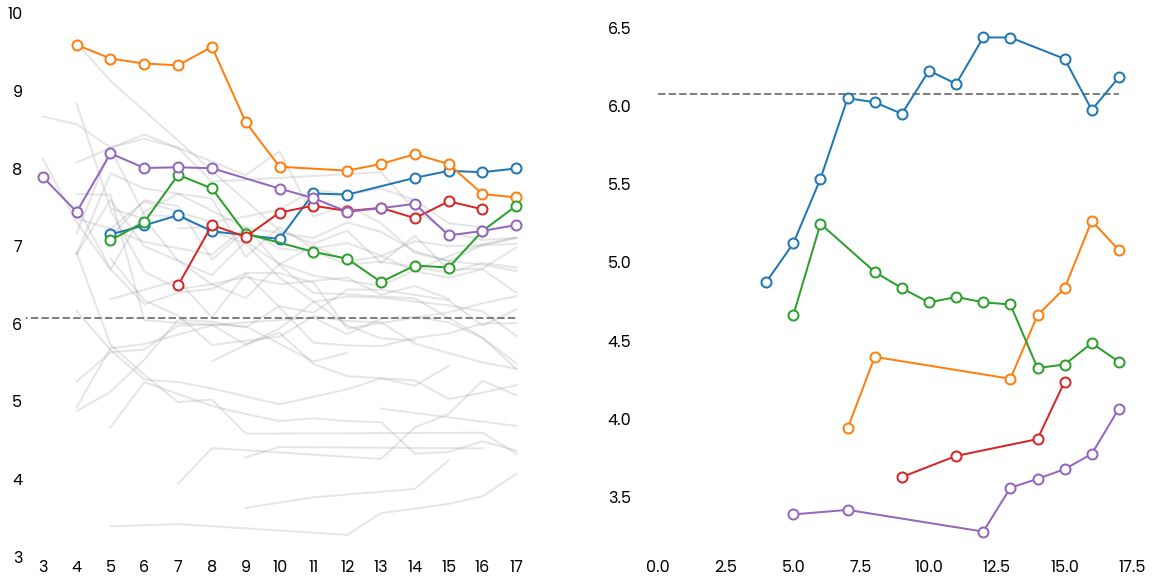

In [58]:
plt.rcParams["font.family"] = "Poppins"
plt.rcParams["font.size"] = 16
plt.rcParams["xtick.major.size"] = 0
plt.rcParams["ytick.major.size"] = 0

fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(nrows=1, ncols=2, hspace=0.03)
ax1 = fig.add_subplot(gs[0, 0], frame_on=False)
ax2 = fig.add_subplot(gs[0, 1], frame_on=False)

# League Average
ax1.plot([0, 17], [league_avg.any_a, league_avg.any_a], linestyle="--", linewidth=2, color="gray", zorder=1)
ax2.plot([0, 17], [league_avg.any_a, league_avg.any_a], linestyle="--", linewidth=2, color="gray", zorder=1)

for qb in qb_list["full_name"][:5]:
    df_temp = df_passing_cum[(df_passing_cum["full_name"] == qb) & (df_passing_cum["yards"] >= 1000)].reset_index(drop=True).copy()
    ax1.plot(df_temp["week"], df_temp["any_a"], linewidth=2, marker="o", markersize=10, markeredgewidth=2, markerfacecolor="white", zorder=2)
    #ax.annotate(qb, xy=(df_temp.iloc[-1].week, df_temp.iloc[-1].any_a), xytext
    
for qb in qb_list["full_name"][5:]:
    df_temp = df_passing_cum[(df_passing_cum["full_name"] == qb) & (df_passing_cum["yards"] >= 1000)].copy()
    #ax.plot(df_temp["week"], df_temp["any_a"], color="gray", alpha=0.2, marker="o", markersize=10, markeredgewidth=2, markerfacecolor="white", zorder=1)
    ax1.plot(df_temp["week"], df_temp["any_a"], linewidth=2, color="gray", alpha=0.2, zorder=1)
    
for qb in qb_list[qb_list["rookie"] == True]["full_name"]:
    df_temp = df_passing_cum[(df_passing_cum["full_name"] == qb) & (df_passing_cum["yards"] >= 1000)].reset_index(drop=True).copy()
    ax2.plot(df_temp["week"], df_temp["any_a"], linewidth=2, marker="o", markersize=10, markeredgewidth=2, markerfacecolor="white", zorder=2)
    #ax.annotate(qb, xy=(df_temp.iloc[-1].week, df_temp.iloc[-1].any_a), xytext  
    
ax1.set_xticks(range(3, 18))
ax1.set_xlim(2.5, 17.5)
ax1.set_ylim(3, 10)
plt.show()